<a href="https://colab.research.google.com/github/NyKunch/TA-sentiment-analysis-indobert/blob/main/TA_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download semua data yang diperlukan

# Inset Lexicon
!wget https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/positive.tsv
!wget https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/negative.tsv

# Dataset
!wget https://raw.githubusercontent.com/NyKunch/TA-sentiment-analysis-indobert/refs/heads/main/DatasetV2%20-%20Ulasan%20Cleaned%20Final.csv
!wget https://raw.githubusercontent.com/NyKunch/TA-sentiment-analysis-indobert/refs/heads/main/DatasetV2%20-%20Perubahan%20Kata.csv

# Text Preprocessing
!pip install Sastrawi

# Modelling
! pip install -q tensorflow==2.13.0
! pip install -q transformers==4.36.2


--2024-11-12 04:20:43--  https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/positive.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41462 (40K) [text/plain]
Saving to: ‘positive.tsv’

positive.tsv        100%[===================>]  40.49K  --.-KB/s    in 0.002s  

2024-11-12 04:20:43 (22.9 MB/s) - ‘positive.tsv’ saved [41462/41462]

--2024-11-12 04:20:44--  https://raw.githubusercontent.com/fajri91/InSet/refs/heads/master/negative.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82788 (81K) [text/plain]
Savi

In [ ]:
import pandas as pd
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import  StopWordRemoverFactory

import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Input, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [ ]:
MAX_LENGTH = 40
BATCH_SIZE = 32
EPOCHS = 5

In [ ]:
# Akses file .csv
ulasan_file_path = 'DatasetV2 - Ulasan Cleaned Final.csv'
df = pd.read_csv(ulasan_file_path)
# df_ulasan = df['review']

negative_file_path = 'negative.tsv'
positive_file_path = 'positive.tsv'
kamus_file_path = 'DatasetV2 - Perubahan Kata.csv'

lexicon_negatif = pd.read_csv(negative_file_path, sep='\t', header=0)
lexicon_positif = pd.read_csv(positive_file_path, sep='\t', header=0)
kamus_preprocessing = pd.read_csv(kamus_file_path)

# Convert lexicon to dict for faster lookup
positif_dict = dict(zip(lexicon_positif['word'], lexicon_positif['weight']))
negatif_dict = dict(zip(lexicon_negatif['word'], lexicon_negatif['weight']))

# Membuat dictionary dari file singkatan untuk penggantian
singkatan_dict = dict(zip(kamus_preprocessing['Kata'], kamus_preprocessing['Perbaikan']))


In [ ]:
# Fungsi untuk mengganti singkatan dengan kata baku
def replace_singkatan(text):
    words = text.split()
    # Ganti singkatan dengan kata baku
    replaced_words = [singkatan_dict.get(word, word) for word in words]
    return ' '.join(replaced_words)

# Fungsi untuk preprocessing teks
def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Mengganti : dan \n dengan spasi
    text = re.sub(r':', ' ', text)
    text = re.sub(r'\\n', ' ', text)

    # Mengganti singkatan dengan kata baku
    text = replace_singkatan(text)

    # Menghilangkan karakter spesial dan angka
    text = re.sub(r'[^a-z\s]', '', text)

    # Menghilangkan stopwords
    stopword_factory = StopWordRemoverFactory()
    stopwords = stopword_factory.get_stop_words()

    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    text = text.split()
    filtered_text = [word for word in text if word not in stopwords]

    text = ' '.join(filtered_text)
    text = stemmer.stem(text)

    return text

# Fungsi untuk memberikan label sentimen
def label_sentiment(text):
    # Preprocess teks ulasan
    clean_text = preprocess_text(text)
    words = clean_text.split()

    # Hitung jumlah kata positif dan negatif
    positif_count = sum(positif_dict.get(word)
                        for word in words
                        if word in positif_dict)
    negatif_count = sum(negatif_dict.get(word)
                        for word in words
                        if word in negatif_dict)

    polarity_sum = positif_count + negatif_count

    # Menentukan label sentimen
    if polarity_sum > 0:
        return f'positif'
    elif polarity_sum < 0:
        return f'negatif'
    else:
        return f'netral'

# Terapkan fungsi untuk memberikan label ke setiap ulasan
df['review'] = df['review'].apply(preprocess_text)
df['sentimen'] = df['review'].apply(label_sentiment)

df_final = df[df['sentimen'].isin(['positif', 'negatif'])]
df_final = df_final[['review', 'sentimen']]

# Mengubah sentimen menjadi numerik biner
sentiment_mapping = {'positif': 1, 'negatif': 0}
df_final['label'] = df_final['sentimen'].map(sentiment_mapping)
df_final = df_final[['review', 'label']]
df_final.head()

,review,label
0,barang aman sesuai pes bahan rada tipis emang ...,1
1,warna putih ijo desain bagus bahan tebal sorry...,0
2,warna sangat bagus sesuai gambar desain lihat ...,1
3,tebal tebal desain sangat tarik warna sangat b...,0
4,warna bagus desain keren soft bahan kayak premium,0


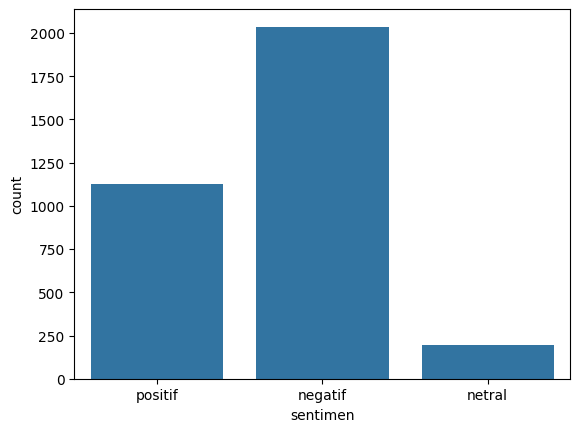

In [ ]:
import seaborn as sns

sns.countplot(x='sentimen', data=df)
plt.show()

In [ ]:
df['sentimen'].value_counts()

,count
sentimen,
negatif,2036
positif,1124
netral,194


In [ ]:
df_final.to_csv('df_final.csv', index=False)

In [ ]:
!wget https://raw.githubusercontent.com/NyKunch/TA-sentiment-analysis-indobert/refs/heads/main/df_final.csv

df_final = pd.read_csv('df_final.csv')
print(df_final.head())

--2024-11-12 04:23:04--  https://raw.githubusercontent.com/NyKunch/TA-sentiment-analysis-indobert/refs/heads/main/df_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 263322 (257K) [text/plain]
Saving to: ‘df_final.csv’

df_final.csv        100%[===================>] 257.15K  --.-KB/s    in 0.005s  

2024-11-12 04:23:04 (54.0 MB/s) - ‘df_final.csv’ saved [263322/263322]

                                              review  label
0  barang aman sesuai pes bahan rada tipis emang ...      1
1  warna putih ijo desain bagus bahan tebal sorry...      0
2  warna sangat bagus sesuai gambar desain lihat ...      1
3  tebal tebal desain sangat tarik warna sangat b...      0
4  warna bagus desain keren soft bahan kayak premium      0


In [ ]:
# Indobert Tokenizer
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

# Konfigurasi tokenisasi
def convert_example_to_feature(sentence):
  return tokenizer.encode_plus(
      sentence,
      add_special_tokens=True,
      padding='max_length',
      truncation='longest_first',
      max_length=40,
      return_attention_mask=True,
      return_token_type_ids=True)

# Fungsi untuk memberi format dictionary pada dataset
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi
  }, label

# Fungsi utama tokenisasi
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []

  for sentence, label in data.to_numpy():
    bert_input = convert_example_to_feature(sentence)
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])
  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list,
                                             token_type_ids_list,
                                             label_list)).map(map_example_to_dict)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [ ]:
df_train, df_test = train_test_split(df_final, test_size=0.2)
df_val, df_test = train_test_split(df_test, test_size=0.5)
df_train.shape, df_test.shape, df_val.shape
print('Training data shape:', df_train.shape)
print('Validation data shape:', df_val.shape)
print('Test data shape:', df_test.shape)

# Lakukan tokenisasi pada dataset yang telah dibagi
train_encoded = encode(df_train).batch(32)
test_encoded = encode(df_test).batch(32)
val_encoded = encode(df_val).batch(32)

Training data shape: (2528, 2)
Validation data shape: (316, 2)
Test data shape: (316, 2)


In [ ]:
# Muat model indoBERT
bert_model = TFBertModel.from_pretrained('indobenchmark/indobert-base-p1')

# Pembuatan Input layer
input_ids = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids')
attention_mask = Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask')

# Ekstraksi output dari BERT
bert_output = bert_model(input_ids=input_ids, attention_mask=attention_mask)[0]

# Menambahkan BiLSTM dan Output layer
bilstm = Bidirectional(LSTM(128, return_sequences=True))(bert_output)
global_max_pool = tf.keras.layers.GlobalMaxPooling1D()(bilstm)
dense_relu = Dense(64, activation='relu')(global_max_pool)
dropout = Dropout(0.3)(dense_relu)
output = Dense(1, activation='sigmoid')(dropout)

# Menggabungkan model
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Model summary
model.summary()

tf_model.h5:   0%|          | 0.00/656M [00:00<?, ?B/s]

Some layers from the model checkpoint at indobenchmark/indobert-base-p1 were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p1.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 40)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 40)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1244413   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   44         'attention_mask[0][0]']      
                             hidden_state=(None, 40, 76                                       

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
%%time
bert_history = model.fit(train_encoded,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=val_encoded)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


79/79 [==============================] - 813s 10s/step - loss: 0.5128 - accuracy: 0.7540 - val_loss: 0.5093 - val_accuracy: 0.7816
Epoch 2/5
79/79 [==============================] - 772s 10s/step - loss: 0.3176 - accuracy: 0.8675 - val_loss: 0.3816 - val_accuracy: 0.8513
Epoch 3/5
79/79 [==============================] - 769s 10s/step - loss: 0.1888 - accuracy: 0.9229 - val_loss: 0.5205 - val_accuracy: 0.8323
Epoch 4/5
79/79 [==============================] - 735s 9s/step - loss: 0.1607 - accuracy: 0.9351 - val_loss: 0.3176 - val_accuracy: 0.8608
Epoch 5/5
79/79 [==============================] - 767s 10s/step - loss: 0.0898 - accuracy: 0.9688 - val_loss: 0.4111 - val_accuracy: 0.8829
CPU times: user 1h 39min 7s, sys: 6min 5s, total: 1h 45min 12s
Wall time: 1h 5min 52s


In [ ]:
# Eksperimental untuk melatih model menggunakan bobot kelas yang lebih rendah

neg_count = (df_final['label'] == 0).sum()
pos_count = (df_final['label'] == 1).sum()

total_data = neg_count + pos_count

neg_weight = total_data / (2 * neg_count)
pos_weight = total_data / (2 * pos_count)

class_weights = {0: neg_weight, 1: pos_weight}
print(class_weights)

{0: 0.7760314341846758, 1: 1.405693950177936}


In [ ]:
# Pelatihan model menggunakan parameter class_weights

%%time
bert_history = model.fit(train_encoded,
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=val_encoded,
                         class_weight=class_weights)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


79/79 [==============================] - 844s 10s/step - loss: 0.5375 - accuracy: 0.7294 - val_loss: 0.4228 - val_accuracy: 0.8165
Epoch 2/5
79/79 [==============================] - 951s 12s/step - loss: 0.3285 - accuracy: 0.8564 - val_loss: 0.3789 - val_accuracy: 0.8418
Epoch 3/5
79/79 [==============================] - 927s 12s/step - loss: 0.1697 - accuracy: 0.9379 - val_loss: 0.4787 - val_accuracy: 0.8418
Epoch 4/5
79/79 [==============================] - 777s 10s/step - loss: 0.1245 - accuracy: 0.9541 - val_loss: 0.4481 - val_accuracy: 0.8608
Epoch 5/5
79/79 [==============================] - 785s 10s/step - loss: 0.1282 - accuracy: 0.9458 - val_loss: 0.4511 - val_accuracy: 0.8228
CPU times: user 1h 48min 13s, sys: 6min 26s, total: 1h 54min 39s
Wall time: 1h 13min 32s


In [ ]:
# Menyimpan model hasil pelatihan

model.save('bert_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Menyimpan model eksperimental

model.save('bert_model_exp.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Memuat model

from google.colab import drive
drive.mount('/content/drive')

loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Tugas Akhir/Model/bert_model.h5', custom_objects={'TFBertModel': TFBertModel})

# Tes
loss, accuracy = loaded_model.evaluate(test_encoded)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/10 [==============================] - 29s 3s/step - loss: 0.3584 - accuracy: 0.9019
Loss: 0.3584305942058563
Accuracy: 0.9018987417221069


In [ ]:
# Create a function for plotting training results
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

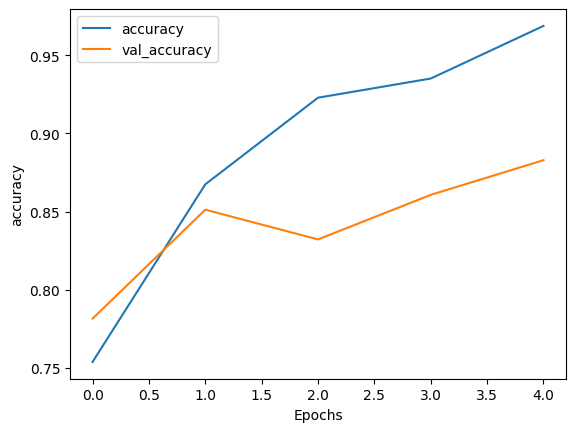

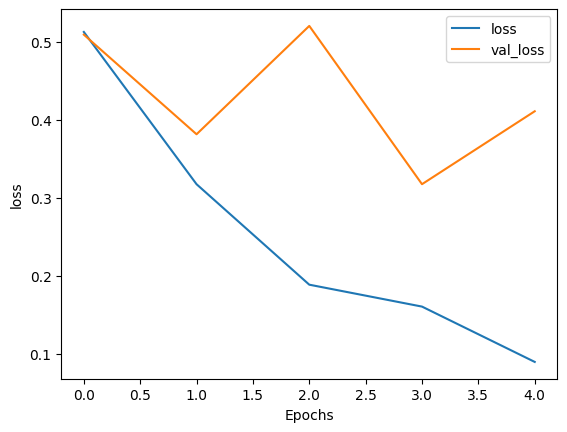

In [ ]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [ ]:
# Evaluasi model menggunakan test_encoded
loss, accuracy = model.evaluate(test_encoded)

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

10/10 [==============================] - 24s 2s/step - loss: 0.3584 - accuracy: 0.9019
Loss: 0.3584305942058563
Accuracy: 0.9018987417221069


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

predictions = model.predict(test_encoded)
predicted_labels = (predictions > 0.5).astype(int)

true_labels = []
for _, label in df_test.to_numpy():
  true_labels.append(label)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
cls_report = classification_report(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Classification Report: {cls_report}")

10/10 [==============================] - 37s 4s/step
Accuracy: 0.9018987341772152
Precision: 0.9111111111111111
Recall: 0.780952380952381
F1 Score: 0.841025641025641
Classification Report:               precision    recall  f1-score   support

           0       0.90      0.96      0.93       211
           1       0.91      0.78      0.84       105

    accuracy                           0.90       316
   macro avg       0.90      0.87      0.89       316
weighted avg       0.90      0.90      0.90       316



In [ ]:
# Matriks evaluasi eksperimental

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

predictions = model.predict(test_encoded)
predicted_labels = (predictions > 0.5).astype(int)

true_labels = []
for _, label in df_test.to_numpy():
  true_labels.append(label)

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
cls_report = classification_report(true_labels, predicted_labels)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Classification Report: {cls_report}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py:639: UserWarning: Input dict contained keys ['token_type_ids'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


10/10 [==============================] - 39s 3s/step
Accuracy: 0.8639240506329114
Precision: 0.7272727272727273
Recall: 0.8602150537634409
F1 Score: 0.7881773399014779
Classification Report:               precision    recall  f1-score   support

           0       0.94      0.87      0.90       223
           1       0.73      0.86      0.79        93

    accuracy                           0.86       316
   macro avg       0.83      0.86      0.84       316
weighted avg       0.88      0.86      0.87       316

